In [3]:
import pymaster as nmt
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

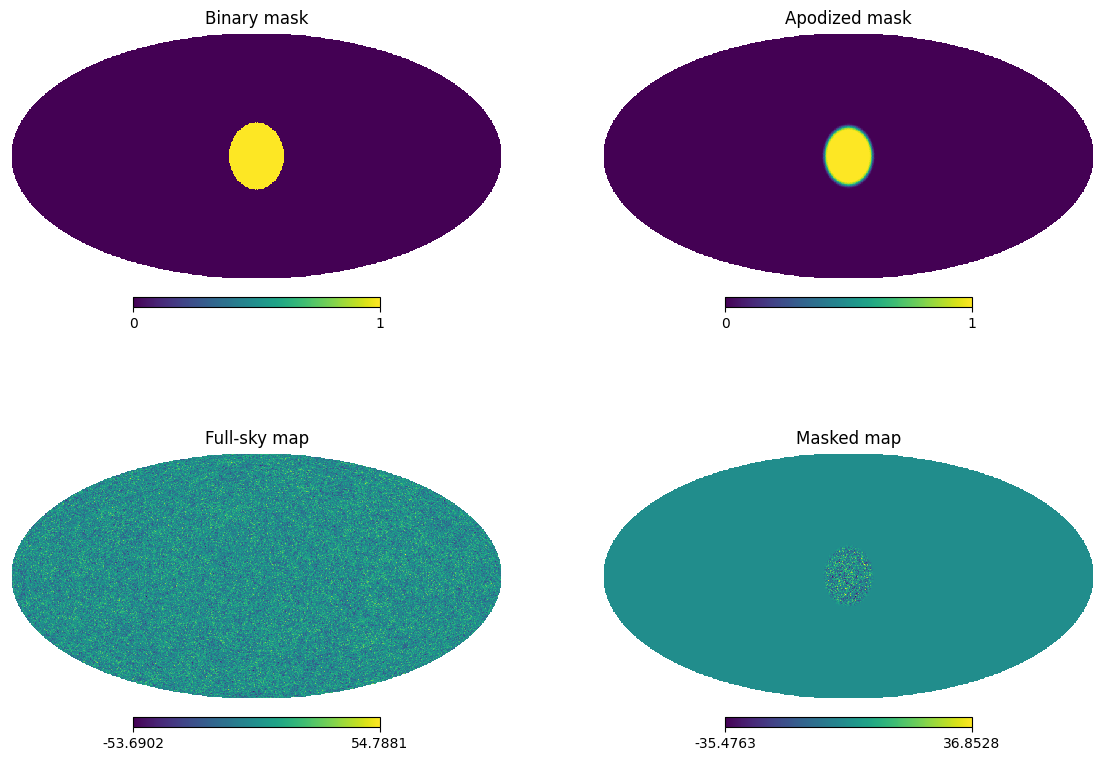

In [4]:
# HEALPix resolution parameter
nside = 256
npix = hp.nside2npix(nside)

# Range of ells to explore and input power spectrum
ls = np.arange(3*nside)
cl_true = 1/(ls+10)

# Simulator
def gen_sim():
    return hp.synfast(cl_true, nside)

# Binary mask
mask_binary = np.zeros(npix)
mask_binary[hp.query_disc(nside, [1, 0, 0], np.radians(20))] = 1

# Apodised mask
# We use a 5-degree "C1" apodisation (see Grain et al. 2009).
mask = nmt.mask_apodization(mask_binary, 5.0, "C1")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.axes(axes[0][0])
hp.mollview(mask_binary, title='Binary mask', hold=True)
plt.axes(axes[0][1])
hp.mollview(mask, title='Apodized mask', hold=True)
mp = gen_sim()
plt.axes(axes[1][0])
hp.mollview(mp, title='Full-sky map', hold=True)
plt.axes(axes[1][1])
hp.mollview(mp*mask, title='Masked map', hold=True)

Generate fields

In [3]:
from importlib.metadata import version

The first 5 harmonic coefficients of the masked map are:
[-0.06866496+0.j  0.00161314+0.j  0.07488752+0.j -0.00367598+0.j
 -0.07083118+0.j]
The first 5 harmonic coefficients of the mask are:
[ 8.27262120e-02+0.j -8.49291022e-20+0.j -8.60449099e-02+0.j
  1.75794210e-19+0.j  7.26256197e-02+0.j]


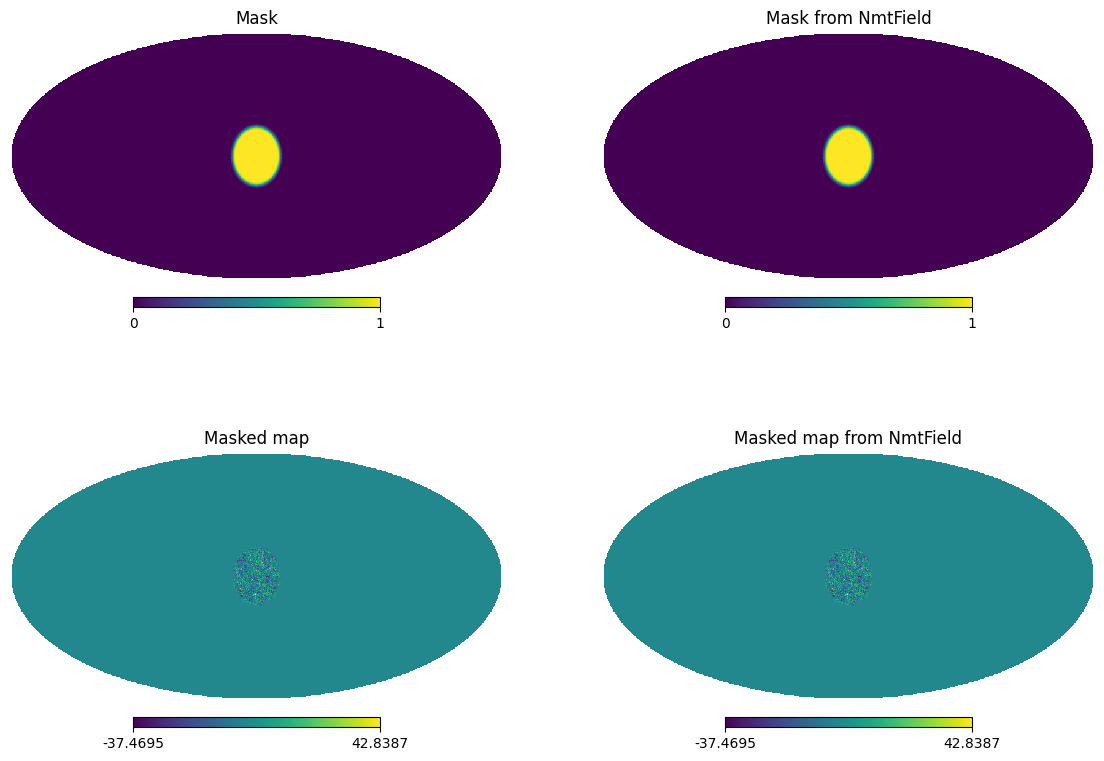

In [4]:
f = nmt.NmtField(mask, [mp], n_iter=0)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.axes(axes[0][0])
hp.mollview(mask, title='Mask', hold=True)
plt.axes(axes[0][1])
hp.mollview(f.get_mask(), title='Mask from NmtField', hold=True)
plt.axes(axes[1][0])
hp.mollview(mp*mask, title='Masked map', hold=True)
plt.axes(axes[1][1])
hp.mollview(f.get_maps()[0], title='Masked map from NmtField', hold=True)

print("The first 5 harmonic coefficients of the masked map are:")
print(f.get_alms()[0][:5])
print("The first 5 harmonic coefficients of the mask are:")
print(f.get_mask_alms()[:5])

### Binning

Text(0.5, 0, '$\\ell$')

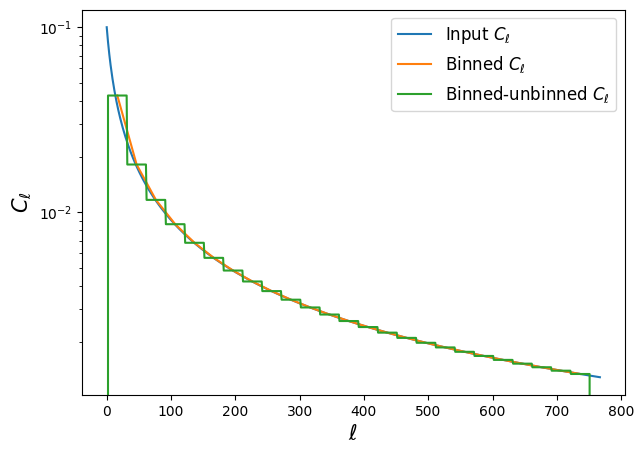

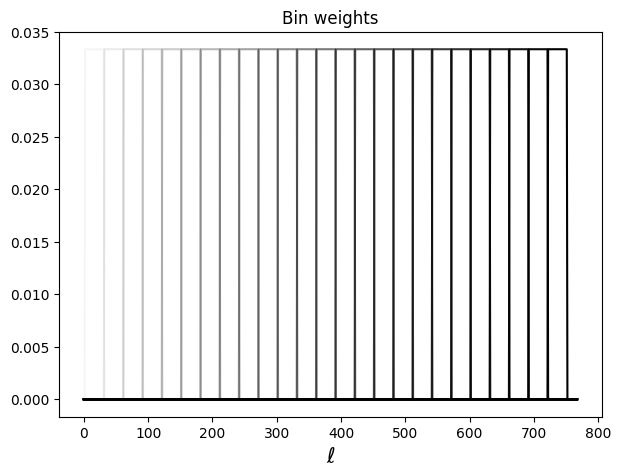

In [5]:
# The default constructor for NmtBins allows you to fine tune
# each of your bandpowers. Here we show only some of the more
# basic constructors (provided as class methods).

# This constructor builds equi-space bandpowers from ell=2
# up to the maximum ell that maps with resolution nside should
# be able to reproduce (3*nside-1)
delta_ell = 30
b1 = nmt.NmtBin.from_nside_linear(nside, nlb=delta_ell)

# This one is very similar. Instead of passing nside, you
# pass the maximum multipole.
b2 = nmt.NmtBin.from_lmax_linear(3*nside-1, nlb=delta_ell)

# Finally, this one constructs bandpowers from their
# corresponding edges.
edges = np.arange(2, 3+delta_ell*((3*nside-1)//delta_ell), delta_ell)
b3 = nmt.NmtBin.from_edges(edges[:-1], edges[1:])

# All the bins above should be equivalent, so let's just
# pick one.
b = b1

# NmtBin contain all information you need about the
# binning scheme you chose. Some basic functionality:
# - effective ells for each bandpower
leff = b1.get_effective_ells()
# - simple binning function
cl_binned = b.bin_cell(cl_true)
# - unbinning (assuming stepwise)
cl_unbinned = b.unbin_cell(cl_binned)
# - binning weights for each bandpower
n_bins = b.get_n_bands()
Fls = np.zeros([n_bins, 3*nside])
for i in range(n_bins):
    Fls[i, b.get_ell_list(i)] = b.get_weight_list(i)

plt.figure(figsize=(7, 5))
plt.plot(ls, cl_true, label=r'Input $C_\ell$')
plt.plot(leff, cl_binned, label=r'Binned $C_\ell$')
plt.plot(ls, cl_unbinned, label=r'Binned-unbinned $C_\ell$')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.legend(fontsize=12)

plt.figure(figsize=(7, 5))
plt.title('Bin weights')
for i, fl in enumerate(Fls):
    plt.plot(ls, fl, 'k-', alpha=(i+1)/n_bins)
plt.xlabel(r'$\ell$', fontsize=15)

### Pseudo-$C_{\ell}$

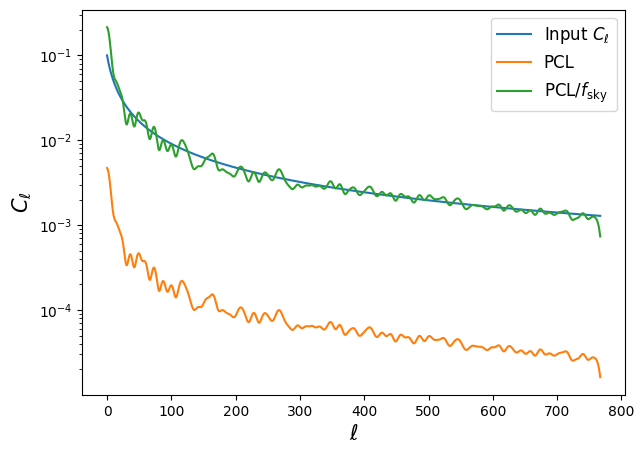

In [6]:
pcl = nmt.compute_coupled_cell(f, f)
fsky = np.mean(f.get_mask()**2)
pcl_corrected = pcl / fsky

plt.figure(figsize=(7, 5))
plt.plot(ls, cl_true, label=r'Input $C_\ell$')
plt.plot(ls, pcl[0], label=r'PCL')
plt.plot(ls, pcl_corrected[0], label=r'PCL/$f_{\rm sky}$')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.legend(fontsize=12)

### Mode-coupling matrix 

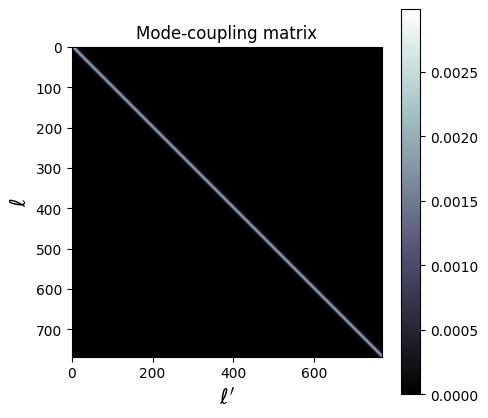

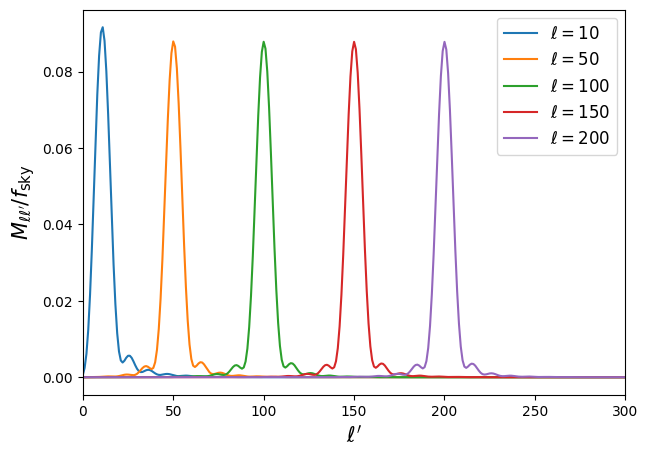

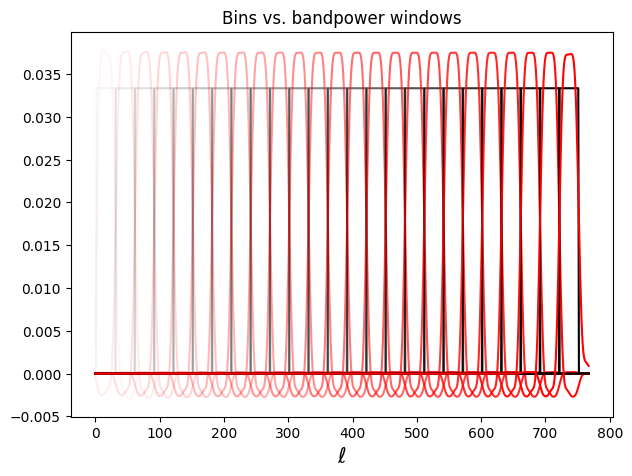

In [7]:
# Create a NaMaster workspace
w = nmt.NmtWorkspace.from_fields(f, f, b) #fields are f, bins are b

# Extract the mode-coupling matrix
mcm = w.get_coupling_matrix()

# Extract bandpower window functions
Bbl = w.get_bandpower_windows().squeeze()

# Plot MCM
plt.figure(figsize=(5, 5))
plt.title('Mode-coupling matrix')
plt.imshow(mcm, cmap='bone')
plt.ylabel("$\\ell$", fontsize=15)
plt.xlabel("$\\ell'$", fontsize=15)
plt.colorbar()

plt.figure(figsize=(7, 5))
for ll in [10, 50, 100, 150, 200]:
    plt.plot(ls, mcm[ll]/fsky, label=f'$\\ell={ll}$')
plt.xlabel("$\\ell'$", fontsize=15)
plt.ylabel("$M_{\\ell \\ell'}/f_{\\rm sky}$", fontsize=15)
plt.legend(fontsize=12)
plt.xlim([0, 300])

plt.figure(figsize=(7, 5))
plt.title('Bins vs. bandpower windows')
for i, fl in enumerate(Fls):
    plt.plot(ls, fl, 'k-', alpha=(i+1)/n_bins)
    plt.plot(ls, Bbl[i], 'r-', alpha=(i+1)/n_bins)
plt.xlabel(r'$\ell$', fontsize=15);

In [17]:
np.sum(mcm, axis = 1)[0]

0.02196399254037706

In [14]:
np.dot(mcm, np.ones(len(mcm)))

array([0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196399,
       0.02196399, 0.02196399, 0.02196399, 0.02196399, 0.02196

# CIB cross-correlation

Confirm that coupling matrix matches Skylens

In [5]:
import pickle

In [16]:
# HEALPix resolution parameter
nside = 1024
npix = hp.nside2npix(nside)

# Range of ells to explore and input power spectrum
LMIN = 100 # don't consider larger scales
ls = np.arange(3*nside)
cl_true = 1/(ls+10)

In [7]:
# read mask and CIB data
#FIXME: we only model 545 GHz for now. 
cibf = '545'

# read mask
foldername = '/Users/tkarim/Documents/research/cib.nosync/data/'
with open(foldername + 'cib/cibmasks_1024_eq_apodized.pkl',
          'rb') as handle:
    cibmask = pickle.load(handle)[cibf]
    
# read data 
with open(foldername + 'cib/cibmasks_1024_eq_data.pkl',
          'rb') as handle:
    cibdata = pickle.load(handle)[cibf]

In [30]:
# read mask and ELG data

elgdata = np.load(foldername + "gal/delta_elg_dr9_rongr.npy")
elgmask = np.load(foldername + "gal/mask_bool_dr9.npy")

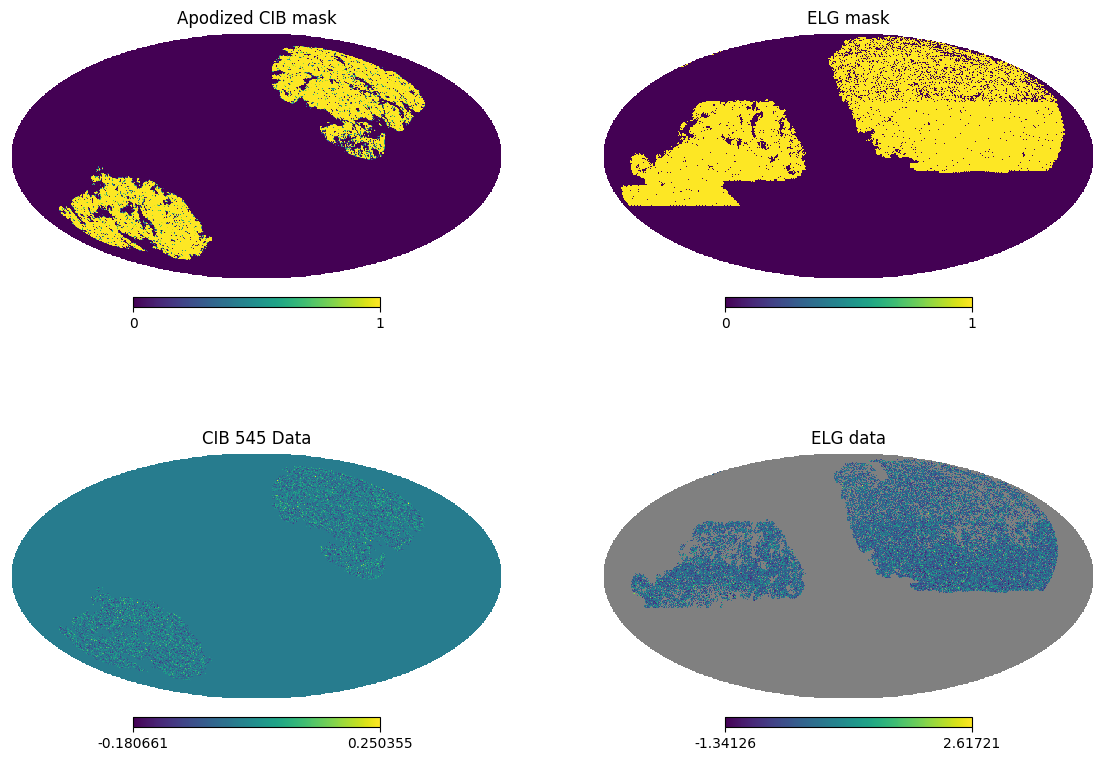

In [31]:
rot = -85
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.axes(axes[0][0])
hp.mollview(cibmask, title='Apodized CIB mask', rot = rot, hold=True)
plt.axes(axes[1][0])
hp.mollview(cibdata, title=f'CIB {cibf} Data', rot = rot, hold=True)
plt.axes(axes[0][1])
hp.mollview(elgmask, title=f'ELG mask', rot = rot, hold=True)
plt.axes(axes[1][1])
hp.mollview(elgdata, title=f'ELG data', rot = rot, hold=True)

In [32]:
# create NmtField object
fcib = nmt.NmtField(cibmask, [cibdata], n_iter=0)
felg = nmt.NmtField(elgmask, [elgdata], n_iter=0)

In [17]:
# binning scheme 

# The default constructor for NmtBins allows you to fine tune
# each of your bandpowers. Here we show only some of the more
# basic constructors (provided as class methods).

# This constructor builds equi-space bandpowers from ell=2
# up to the maximum ell that maps with resolution nside should
# be able to reproduce (3*nside-1)
delta_ell = 30
b1 = nmt.NmtBin.from_nside_linear(nside, nlb=delta_ell)

# This one is very similar. Instead of passing nside, you
# pass the maximum multipole.
b2 = nmt.NmtBin.from_lmax_linear(3*nside-1, nlb=delta_ell)

# Finally, this one constructs bandpowers from their
# corresponding edges.
edges = np.arange(2, 3+delta_ell*((3*nside-1)//delta_ell), delta_ell)
b3 = nmt.NmtBin.from_edges(edges[:-1], edges[1:])

# All the bins above should be equivalent, so let's just
# pick one.
b = b1

# NmtBin contain all information you need about the
# binning scheme you chose. Some basic functionality:
# - effective ells for each bandpower
leff = b1.get_effective_ells()
# - simple binning function
cl_binned = b.bin_cell(cl_true)
# - unbinning (assuming stepwise)
cl_unbinned = b.unbin_cell(cl_binned)
# - binning weights for each bandpower
n_bins = b.get_n_bands()
Fls = np.zeros([n_bins, 3*nside])
for i in range(n_bins):
    Fls[i, b.get_ell_list(i)] = b.get_weight_list(i)

Text(0.5, 0, '$\\ell$')

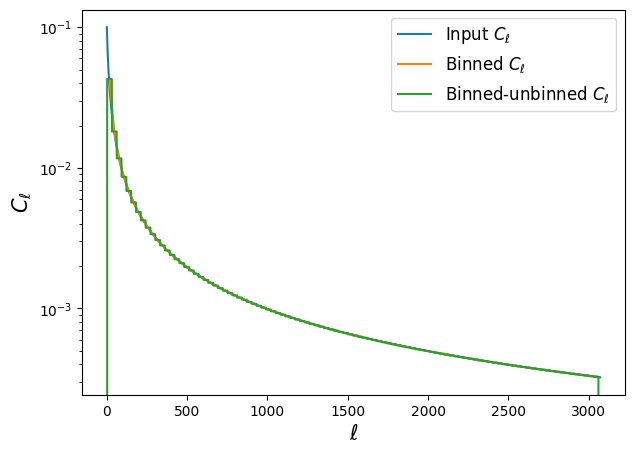

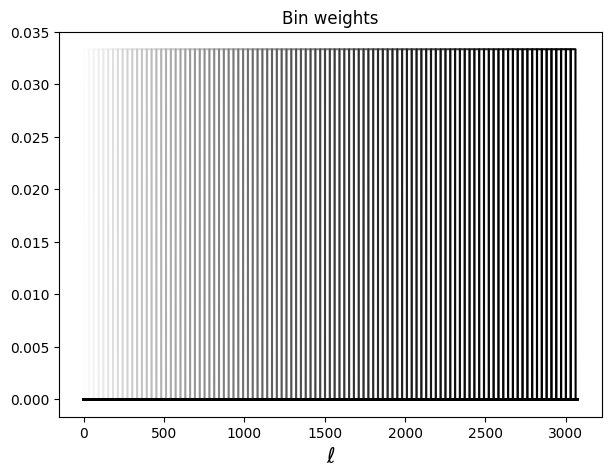

In [18]:
plt.figure(figsize=(7, 5))
plt.plot(ls, cl_true, label=r'Input $C_\ell$')
plt.plot(leff, cl_binned, label=r'Binned $C_\ell$')
plt.plot(ls, cl_unbinned, label=r'Binned-unbinned $C_\ell$')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.legend(fontsize=12)

plt.figure(figsize=(7, 5))
plt.title('Bin weights')
for i, fl in enumerate(Fls):
    plt.plot(ls, fl, 'k-', alpha=(i+1)/n_bins)
plt.xlabel(r'$\ell$', fontsize=15)

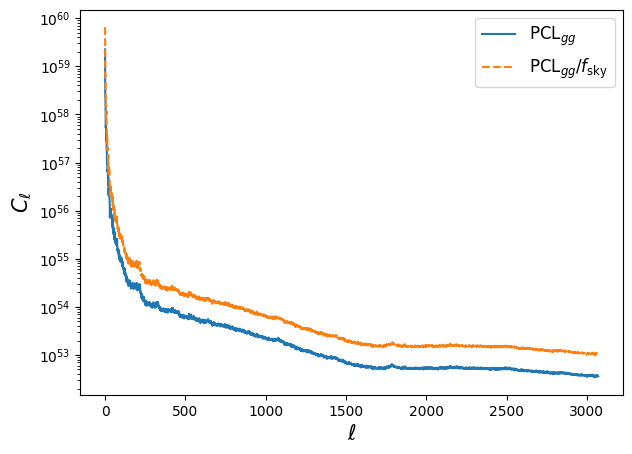

In [39]:
# calculate pcl for CIB,CIB, gg, g-CIB

pcl_cc = nmt.compute_coupled_cell(fcib, fcib)
fsky_cc = np.mean(fcib.get_mask()**2)
pcl_cc_corrected = pcl_cc / fsky_cc

pcl_gg = nmt.compute_coupled_cell(felg, felg)
fsky_gg = np.mean(felg.get_mask()**2)
pcl_gg_corrected = pcl_gg / fsky_gg

pcl_cg = nmt.compute_coupled_cell(fcib, felg)
fsky_cg = np.mean(felg.get_mask() * fcib.get_mask())
pcl_cg_corrected = pcl_cg / fsky_cg

plt.figure(figsize=(7, 5))
#plt.plot(ls, cl_true, label=r'Input $C_\ell$')
# plt.plot(ls, pcl_cc[0], label=r'PCL$_{II}$')
# plt.plot(ls, pcl_cc_corrected[0], label=r'PCL$_{II}$/$f_{\rm sky}$',
#          ls = '--')

plt.plot(ls, pcl_gg[0], label=r'PCL$_{gg}$')
plt.plot(ls, pcl_gg_corrected[0], label=r'PCL$_{gg}$/$f_{\rm sky}$',
         ls = '--')

# plt.plot(ls, pcl_cg[0], label=r'PCL$_{gI}$')
# plt.plot(ls, pcl_cg_corrected[0], label=r'PCL$_{gI}$/$f_{\rm sky}$',
#          ls = '--')

plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.legend(fontsize=12)

In [43]:
full_gg = nmt.compute_full_master(felg, felg, b)

In [35]:
# coupling matrix
# Create a NaMaster workspace
w = nmt.NmtWorkspace.from_fields(fcib, fcib, b)

# Extract the mode-coupling matrix
mcm = w.get_coupling_matrix()

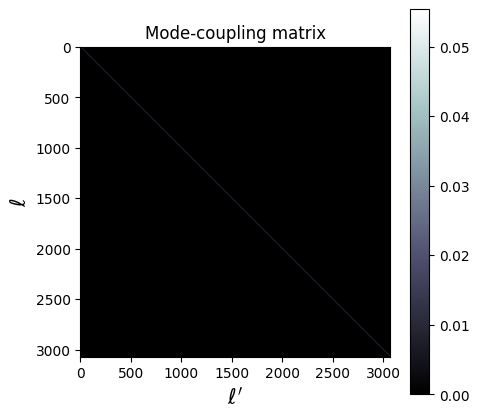

In [36]:
# Plot MCM
plt.figure(figsize=(5, 5))
plt.title('Mode-coupling matrix')
plt.imshow(mcm, cmap='bone')
plt.ylabel("$\\ell$", fontsize=15)
plt.xlabel("$\\ell'$", fontsize=15)
plt.colorbar()

In [38]:
mcm[0,0:10]

array([0.02174039, 0.00058856, 0.05539248, 0.00027472, 0.01622849,
       0.000992  , 0.00346846, 0.00116841, 0.00419702, 0.00049351])